In [9]:

# --- IMPORTS ---
import pandas as pd
import requests
import os
import numpy as np
!pip install python-igraph
import networkx as nx
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import igraph as ig
import sys
from sklearn import preprocessing
from __future__ import division
import itertools
import numbers
from warnings import warn
from abc import ABCMeta, abstractmethod
# we can assume joblib is present because it's required by sklearn anyway
from joblib import Parallel, delayed
from sklearn.base import ClassifierMixin
from six import with_metaclass
from six.moves import zip
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import (check_random_state, check_X_y, check_array, column_or_1d,)
from sklearn.utils.random import sample_without_replacement
from sklearn.utils.validation import has_fit_parameter, check_is_fitted
from sklearn.utils import indices_to_mask, check_consistent_length
from sklearn.utils.metaestimators import if_delegate_has_method
from sklearn.utils.multiclass import check_classification_targets
from sklearn.ensemble import BaseEnsemble
from sklearn.ensemble._base import _partition_estimators
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_sample_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score


data = pd.read_csv("creditcard.csv") 


In [10]:
# 2. Split in features en target
X = data.drop(columns=["Class"])
y = data["Class"]

# --- TRAIN-TEST SPLIT ---
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

# Further splitting the train set into Train and Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42)


In [11]:
def maak_pu_setting_van_echte_labels(y_true, label_ratio, random_state=42):
    
    np.random.seed(random_state)

    
    positieve_indexen = np.where(y_true == 1)[0]
    n_gelabeld = int(label_ratio * len(positieve_indexen))
    gelabelde_indexen = np.random.choice(positieve_indexen, size=n_gelabeld, replace=False)

    y_pu = np.zeros_like(y_true)
    y_pu[gelabelde_indexen] = 1

    return y_pu, y_true, gelabelde_indexen



In [20]:
y_train_pu, y_train, gelabelde_indexen = maak_pu_setting_van_echte_labels(y_train, label_ratio=0.1)


In [21]:
"""Bagging meta-estimator for PU learning.
Any scikit-learn estimator should work as the base estimator.
This implementation is fully compatible with scikit-learn, and is in fact based
on the code of the sklearn.ensemble.BaggingClassifier class with very minor
changes.
"""

# Author: Gilles Louppe <g.louppe@gmail.com>
# License: BSD 3 clause
#


__all__ = ["BaggingPuClassifier"]

MAX_INT = np.iinfo(np.int32).max


def _generate_indices(random_state, bootstrap, n_population, n_samples):
    """Draw randomly sampled indices."""
    # Draw sample indices
    if bootstrap:
        indices = random_state.randint(0, n_population, n_samples)
    else:
        indices = sample_without_replacement(n_population, n_samples,
                                             random_state=random_state)

    return indices


def _generate_bagging_indices(random_state, bootstrap_features,
                              bootstrap_samples, n_features, n_samples,
                              max_features, max_samples):
    """Randomly draw feature and sample indices."""
    # Get valid random state
    random_state = check_random_state(random_state)

    # Draw indices
    feature_indices = _generate_indices(random_state, bootstrap_features,
                                        n_features, max_features)
    sample_indices = _generate_indices(random_state, bootstrap_samples,
                                       n_samples, max_samples)

    return feature_indices, sample_indices


def _parallel_build_estimators(n_estimators, ensemble, X, y, sample_weight,
                               seeds, total_n_estimators, verbose):
    """Private function used to build a batch of estimators within a job."""
    # Retrieve settings
    n_samples, n_features = X.shape
    max_features = ensemble._max_features
    max_samples = ensemble._max_samples
    bootstrap = ensemble.bootstrap
    bootstrap_features = ensemble.bootstrap_features
    support_sample_weight = has_fit_parameter(ensemble.base_estimator_,
                                              "sample_weight")
    if not support_sample_weight and sample_weight is not None:
        raise ValueError("The base estimator doesn't support sample weight")

    # Build estimators
    estimators = []
    estimators_features = []

    for i in range(n_estimators):
        if verbose > 1:
            print("Building estimator %d of %d for this parallel run "
                  "(total %d)..." % (i + 1, n_estimators, total_n_estimators))

        random_state = np.random.RandomState(seeds[i])
        estimator = ensemble._make_estimator(append=False,
                                             random_state=random_state)

        # ============ MAIN MODIFICATION FOR PU LEARNING =============
        iP = [pair[0] for pair in enumerate(y) if pair[1] == 1]
        iU = [pair[0] for pair in enumerate(y) if pair[1] < 1]
        features, indices = _generate_bagging_indices(random_state,
                                                      bootstrap_features,
                                                      bootstrap, n_features,
                                                      len(iU), max_features,
                                                      max_samples)
        indices = [iU[i] for i in indices] + iP
        # ============================================================

        # Draw samples, using sample weights, and then fit
        if support_sample_weight:
            if sample_weight is None:
                curr_sample_weight = np.ones((n_samples,))
            else:
                curr_sample_weight = sample_weight.copy()

            if bootstrap:
                sample_counts = np.bincount(indices, minlength=n_samples)
                curr_sample_weight *= sample_counts
            else:
                not_indices_mask = ~indices_to_mask(indices, n_samples)
                curr_sample_weight[not_indices_mask] = 0

            estimator.fit(X[:, features], y, sample_weight=curr_sample_weight)

        # Draw samples, using a mask, and then fit
        else:
            estimator.fit((X[indices])[:, features], y[indices])

        estimators.append(estimator)
        estimators_features.append(features)

    return estimators, estimators_features


def _parallel_predict_proba(estimators, estimators_features, X, n_classes):
    """Private function used to compute (proba-)predictions within a job."""
    n_samples = X.shape[0]
    proba = np.zeros((n_samples, n_classes))

    for estimator, features in zip(estimators, estimators_features):
        if hasattr(estimator, "predict_proba"):
            proba_estimator = estimator.predict_proba(X[:, features])

            if n_classes == len(estimator.classes_):
                proba += proba_estimator

            else:  # pragma: no cover
                proba[:, estimator.classes_] += \
                    proba_estimator[:, range(len(estimator.classes_))]

        else:
            # Resort to voting
            predictions = estimator.predict(X[:, features])

            for i in range(n_samples):
                proba[i, predictions[i]] += 1

    return proba


def _parallel_predict_log_proba(estimators, estimators_features, X, n_classes):
    """Private function used to compute log probabilities within a job."""
    n_samples = X.shape[0]
    log_proba = np.empty((n_samples, n_classes))
    log_proba.fill(-np.inf)
    all_classes = np.arange(n_classes, dtype=np.int)

    for estimator, features in zip(estimators, estimators_features):
        log_proba_estimator = estimator.predict_log_proba(X[:, features])

        if n_classes == len(estimator.classes_):
            log_proba = np.logaddexp(log_proba, log_proba_estimator)

        else:  # pragma: no cover
            log_proba[:, estimator.classes_] = np.logaddexp(
                log_proba[:, estimator.classes_],
                log_proba_estimator[:, range(len(estimator.classes_))])

            missing = np.setdiff1d(all_classes, estimator.classes_)
            log_proba[:, missing] = np.logaddexp(log_proba[:, missing],
                                                 -np.inf)

    return log_proba


def _parallel_decision_function(estimators, estimators_features, X):
    """Private function used to compute decisions within a job."""
    return sum(estimator.decision_function(X[:, features])
               for estimator, features in zip(estimators,
                                              estimators_features))


class BaseBaggingPU(with_metaclass(ABCMeta, BaseEnsemble)):
    """Base class for Bagging PU meta-estimator.
    Warning: This class should not be used directly. Use derived classes
    instead.
    """

    @abstractmethod
    def __init__(self,
                 base_estimator=None,
                 n_estimators=10,
                 max_samples=1.0,
                 max_features=1.0,
                 bootstrap=True,
                 bootstrap_features=False,
                 oob_score=True,
                 warm_start=False,
                 n_jobs=1,
                 random_state=None,
                 verbose=0):
        super(BaseBaggingPU, self).__init__(
            base_estimator=base_estimator,
            n_estimators=n_estimators)

        self.max_samples = max_samples
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.bootstrap_features = bootstrap_features
        self.oob_score = oob_score
        self.warm_start = warm_start
        self.n_jobs = n_jobs
        self.random_state = random_state
        self.verbose = verbose

    def fit(self, X, y, sample_weight=None):
        """Build a Bagging ensemble of estimators from the training
           set (X, y).
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape = [n_samples, n_features]
            The training input samples. Sparse matrices are accepted only if
            they are supported by the base estimator.
        y : array-like, shape = [n_samples]
            The target values (1 for positive, 0 for unlabeled).
        sample_weight : array-like, shape = [n_samples] or None
            Sample weights. If None, then samples are equally weighted.
            Note that this is supported only if the base estimator supports
            sample weighting.
        Returns
        -------
        self : object
            Returns self.
        """
        return self._fit(X, y, self.max_samples, sample_weight=sample_weight)

    def _fit(self, X, y, max_samples=None, max_depth=None, sample_weight=None):
        """Build a Bagging ensemble of estimators from the training
           set (X, y).
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape = [n_samples, n_features]
            The training input samples. Sparse matrices are accepted only if
            they are supported by the base estimator.
        y : array-like, shape = [n_samples]
            The target values (1 for positive, 0 for unlabeled).
        max_samples : int or float, optional (default=None)
            Argument to use instead of self.max_samples.
        max_depth : int, optional (default=None)
            Override value used when constructing base estimator. Only
            supported if the base estimator has a max_depth parameter.
        sample_weight : array-like, shape = [n_samples] or None
            Sample weights. If None, then samples are equally weighted.
            Note that this is supported only if the base estimator supports
            sample weighting.
        Returns
        -------
        self : object
            Returns self.
        """
        random_state = check_random_state(self.random_state)

        self.y = y

        # Convert data
        X, y = check_X_y(X, y, ['csr', 'csc'])
        if sample_weight is not None:
            sample_weight = check_array(sample_weight, ensure_2d=False)
            check_consistent_length(y, sample_weight)

        # Remap output
        n_samples, self.n_features_ = X.shape
        self._n_samples = n_samples
        y = self._validate_y(y)

        # Check parameters
        self._validate_estimator()

        if max_depth is not None:  # pragma: no cover
            self.base_estimator_.max_depth = max_depth

        # Validate max_samples
        if max_samples is None:  # pragma: no cover
            max_samples = self.max_samples
        elif not isinstance(max_samples, (numbers.Integral, np.integer)):
            max_samples = int(max_samples * sum(y < 1))

        if not (0 < max_samples <= sum(y < 1)):
            raise ValueError(
                "max_samples must be positive"
                " and no larger than the number of unlabeled points")

        # Store validated integer row sampling value
        self._max_samples = max_samples

        # Validate max_features
        if isinstance(self.max_features, (numbers.Integral, np.integer)):
            max_features = self.max_features
        else:  # float
            max_features = int(self.max_features * self.n_features_)

        if not (0 < max_features <= self.n_features_):
            raise ValueError("max_features must be in (0, n_features]")

        # Store validated integer feature sampling value
        self._max_features = max_features

        # Other checks
        if not self.bootstrap and self.oob_score:
            raise ValueError("Out of bag estimation only available"
                             " if bootstrap=True")

        if self.warm_start and self.oob_score:
            raise ValueError("Out of bag estimate only available"
                             " if warm_start=False")

        if hasattr(self, "oob_score_") and self.warm_start:  # pragma: no cover
            del self.oob_score_  # pragma: no covr

        if not self.warm_start or not hasattr(self, 'estimators_'):
            # Free allocated memory, if any
            self.estimators_ = []
            self.estimators_features_ = []

        n_more_estimators = self.n_estimators - len(self.estimators_)

        if n_more_estimators < 0:  # pragma: no cover
            raise ValueError('n_estimators=%d must be larger or equal to '
                             'len(estimators_)=%d when warm_start==True'
                             % (self.n_estimators, len(self.estimators_)))

        if n_more_estimators == 0:
            warn("Warm-start fitting without increasing n_estimators does not "
                 "fit new trees.")
            return self

        # Parallel loop
        n_jobs, n_estimators, starts = _partition_estimators(n_more_estimators,
                                                             self.n_jobs)
        total_n_estimators = sum(n_estimators)

        # Advance random state to state after training
        # the first n_estimators
        if self.warm_start and len(self.estimators_) > 0:  # pragma: no cover
            random_state.randint(MAX_INT, size=len(self.estimators_))

        seeds = random_state.randint(MAX_INT, size=n_more_estimators)
        self._seeds = seeds

        all_results = Parallel(n_jobs=n_jobs, verbose=self.verbose)(
            delayed(_parallel_build_estimators)(
                n_estimators[i],
                self,
                X,
                y,
                sample_weight,
                seeds[starts[i]:starts[i + 1]],
                total_n_estimators,
                verbose=self.verbose)
            for i in range(n_jobs))

        # Reduce
        self.estimators_ += list(itertools.chain.from_iterable(
            t[0] for t in all_results))
        self.estimators_features_ += list(itertools.chain.from_iterable(
            t[1] for t in all_results))

        if self.oob_score:
            self._set_oob_score(X, y)

        return self

    @abstractmethod
    def _set_oob_score(self, X, y):
        """Calculate out of bag predictions and score."""

    def _validate_y(self, y):  # pragma: no cover
        # Default implementation
        return column_or_1d(y, warn=True)

    def _get_estimators_indices(self):
        # Get drawn indices along both sample and feature axes
        for seed in self._seeds:
            # Operations accessing random_state must be performed identically
            # to those in _parallel_build_estimators()
            random_state = np.random.RandomState(seed)

            # ============ MAIN MODIFICATION FOR PU LEARNING =============
            iP = [pair[0] for pair in enumerate(self.y) if pair[1] == 1]
            iU = [pair[0] for pair in enumerate(self.y) if pair[1] < 1]

            feature_indices, sample_indices = _generate_bagging_indices(
                random_state, self.bootstrap_features, self.bootstrap,
                self.n_features_, len(iU), self._max_features,
                self._max_samples)

            sample_indices = [iU[i] for i in sample_indices] + iP
            # ============================================================

            yield feature_indices, sample_indices

    @property
    def estimators_samples_(self):
        """The subset of drawn samples for each base estimator.
        Returns a dynamically generated list of boolean masks identifying
        the samples used for fitting each member of the ensemble, i.e.,
        the in-bag samples.
        Note: the list is re-created at each call to the property in order
        to reduce the object memory footprint by not storing the sampling
        data. Thus fetching the property may be slower than expected.
        """
        sample_masks = []
        for _, sample_indices in self._get_estimators_indices():
            mask = indices_to_mask(sample_indices, self._n_samples)
            sample_masks.append(mask)

        return sample_masks


class BaggingPuClassifier(BaseBaggingPU, ClassifierMixin):
    """A Bagging PU classifier.
    Adapted from sklearn.ensemble.BaggingClassifier, based on
    A bagging SVM to learn from positive and unlabeled examples (2013)
    by Mordelet and Vert
    http://dx.doi.org/10.1016/j.patrec.2013.06.010
    http://members.cbio.mines-paristech.fr/~jvert/svn/bibli/local/Mordelet2013bagging.pdf
    Parameters
    ----------
    base_estimator : object or None, optional (default=None)
        The base estimator to fit on random subsets of the dataset.
        If None, then the base estimator is a decision tree.
    n_estimators : int, optional (default=10)
        The number of base estimators in the ensemble.
    max_samples : int or float, optional (default=1.0)
        The number of unlabeled samples to draw to train each base estimator.
    max_features : int or float, optional (default=1.0)
        The number of features to draw from X to train each base estimator.
        - If int, then draw max_features features.
        - If float, then draw max_features * X.shape[1] features.
    bootstrap : boolean, optional (default=True)
        Whether samples are drawn with replacement.
    bootstrap_features : boolean, optional (default=False)
        Whether features are drawn with replacement.
    oob_score : bool, optional (default=True)
        Whether to use out-of-bag samples to estimate
        the generalization error.
    warm_start : bool, optional (default=False)
        When set to True, reuse the solution of the previous call to fit
        and add more estimators to the ensemble, otherwise, just fit
        a whole new ensemble.
    n_jobs : int, optional (default=1)
        The number of jobs to run in parallel for both fit and predict.
        If -1, then the number of jobs is set to the number of cores.
    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by np.random.
    verbose : int, optional (default=0)
        Controls the verbosity of the building process.
    Attributes
    ----------
    base_estimator_ : estimator
        The base estimator from which the ensemble is grown.
    estimators_ : list of estimators
        The collection of fitted base estimators.
    estimators_samples_ : list of arrays
        The subset of drawn samples (i.e., the in-bag samples) for each base
        estimator. Each subset is defined by a boolean mask.
    estimators_features_ : list of arrays
        The subset of drawn features for each base estimator.
    classes_ : array of shape = [n_classes]
        The classes labels.
    n_classes_ : int or list
        The number of classes.
    oob_score_ : float
        Score of the training dataset obtained using an out-of-bag estimate.
    oob_decision_function_ : array of shape = [n_samples, n_classes]
        Decision function computed with out-of-bag estimate on the training
        set. Positive data points, and perhaps some of the unlabeled,
        are left out during the bootstrap. In these cases,
        oob_decision_function_ contains NaN.
    """
    def __init__(self,
                 base_estimator=None,
                 n_estimators=10,
                 max_samples=1.0,
                 max_features=1.0,
                 bootstrap=True,
                 bootstrap_features=False,
                 oob_score=True,
                 warm_start=False,
                 n_jobs=1,
                 random_state=None,
                 verbose=0):

        super(BaggingPuClassifier, self).__init__(
            base_estimator,
            n_estimators=n_estimators,
            max_samples=max_samples,
            max_features=max_features,
            bootstrap=bootstrap,
            bootstrap_features=bootstrap_features,
            oob_score=oob_score,
            warm_start=warm_start,
            n_jobs=n_jobs,
            random_state=random_state,
            verbose=verbose)

    def _validate_estimator(self):
        """Check the estimator and set the base_estimator_ attribute."""
        super(BaggingPuClassifier, self)._validate_estimator(
            default=DecisionTreeClassifier())

    def _set_oob_score(self, X, y):
        n_samples = y.shape[0]
        n_classes_ = self.n_classes_

        predictions = np.zeros((n_samples, n_classes_))

        for estimator, samples, features in zip(self.estimators_,
                                                self.estimators_samples_,
                                                self.estimators_features_):
            # Create mask for OOB samples
            mask = ~samples

            if hasattr(estimator, "predict_proba"):
                predictions[mask, :] += estimator.predict_proba(
                    (X[mask, :])[:, features])

            else:
                p = estimator.predict((X[mask, :])[:, features])
                j = 0

                for i in range(n_samples):
                    if mask[i]:
                        predictions[i, p[j]] += 1
                        j += 1

        # Modified: no warnings about non-OOB points (i.e. positives)
        with np.errstate(invalid='ignore'):
            denominator = predictions.sum(axis=1)[:, np.newaxis]
            oob_decision_function = predictions / denominator
            oob_score = accuracy_score(y, np.argmax(predictions, axis=1))

        self.oob_decision_function_ = oob_decision_function
        self.oob_score_ = oob_score

    def _validate_y(self, y):
        y = column_or_1d(y, warn=True)
        check_classification_targets(y)
        self.classes_, y = np.unique(y, return_inverse=True)
        self.n_classes_ = len(self.classes_)

        return y

    def predict(self, X):
        """Predict class for X.
        The predicted class of an input sample is computed as the class with
        the highest mean predicted probability. If base estimators do not
        implement a `predict_proba method, then it resorts to voting.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape = [n_samples, n_features]
            The training input samples. Sparse matrices are accepted only if
            they are supported by the base estimator.
        Returns
        -------
        y : array of shape = [n_samples]
            The predicted classes.
        """
        predicted_probabilitiy = self.predict_proba(X)
        return self.classes_.take((np.argmax(predicted_probabilitiy, axis=1)),
                                  axis=0)

    def predict_proba(self, X):
        """Predict class probabilities for X.
        The predicted class probabilities of an input sample is computed as
        the mean predicted class probabilities of the base estimators in the
        ensemble. If base estimators do not implement a `predict_proba
        method, then it resorts to voting and the predicted class probabilities
        of an input sample represents the proportion of estimators predicting
        each class.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape = [n_samples, n_features]
            The training input samples. Sparse matrices are accepted only if
            they are supported by the base estimator.
        Returns
        -------
        p : array of shape = [n_samples, n_classes]
            The class probabilities of the input samples. The order of the
            classes corresponds to that in the attribute classes_.
        """
        check_is_fitted(self, "classes_")
        # Check data
        X = check_array(X, accept_sparse=['csr', 'csc'])

        if self.n_features_ != X.shape[1]:
            raise ValueError("Number of features of the model must "
                             "match the input. Model n_features is {0} and "
                             "input n_features is {1}."
                             "".format(self.n_features_, X.shape[1]))

        # Parallel loop
        n_jobs, n_estimators, starts = _partition_estimators(self.n_estimators,
                                                             self.n_jobs)

        all_proba = Parallel(n_jobs=n_jobs, verbose=self.verbose)(
            delayed(_parallel_predict_proba)(
                self.estimators_[starts[i]:starts[i + 1]],
                self.estimators_features_[starts[i]:starts[i + 1]],
                X,
                self.n_classes_)
            for i in range(n_jobs))

        # Reduce
        proba = sum(all_proba) / self.n_estimators

        return proba

    def predict_log_proba(self, X):
        """Predict class log-probabilities for X.
        The predicted class log-probabilities of an input sample is computed as
        the log of the mean predicted class probabilities of the base
        estimators in the ensemble.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape = [n_samples, n_features]
            The training input samples. Sparse matrices are accepted only if
            they are supported by the base estimator.
        Returns
        -------
        p : array of shape = [n_samples, n_classes]
            The class log-probabilities of the input samples. The order of the
            classes corresponds to that in the attribute classes_.
        """
        check_is_fitted(self, "classes_")
        if hasattr(self.base_estimator_, "predict_log_proba"):
            # Check data
            X = check_array(X, accept_sparse=['csr', 'csc'])

            if self.n_features_ != X.shape[1]:
                raise ValueError("Number of features of the model must "
                                 "match the input. Model n_features is {0} "
                                 "and input n_features is {1} "
                                 "".format(self.n_features_, X.shape[1]))

            # Parallel loop
            n_jobs, n_estimators, starts = _partition_estimators(
                self.n_estimators, self.n_jobs)

            all_log_proba = Parallel(n_jobs=n_jobs, verbose=self.verbose)(
                delayed(_parallel_predict_log_proba)(
                    self.estimators_[starts[i]:starts[i + 1]],
                    self.estimators_features_[starts[i]:starts[i + 1]],
                    X,
                    self.n_classes_)
                for i in range(n_jobs))

            # Reduce
            log_proba = all_log_proba[0]

            for j in range(1, len(all_log_proba)):  # pragma: no cover
                log_proba = np.logaddexp(log_proba, all_log_proba[j])

            log_proba -= np.log(self.n_estimators)

            return log_proba
        # else, the base estimator has no predict_log_proba, so...
        return np.log(self.predict_proba(X))

    @if_delegate_has_method(delegate='base_estimator')
    def decision_function(self, X):
        """Average of the decision functions of the base classifiers.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape = [n_samples, n_features]
            The training input samples. Sparse matrices are accepted only if
            they are supported by the base estimator.
        Returns
        -------
        score : array, shape = [n_samples, k]
            The decision function of the input samples. The columns correspond
            to the classes in sorted order, as they appear in the attribute
            `classes_. Regression and binary classification are special
            cases with `k == 1, otherwise k==n_classes.
        """
        check_is_fitted(self, "classes_")

        # Check data
        X = check_array(X, accept_sparse=['csr', 'csc'])

        if self.n_features_ != X.shape[1]:
            raise ValueError("Number of features of the model must "
                             "match the input. Model n_features is {0} and "
                             "input n_features is {1} "
                             "".format(self.n_features_, X.shape[1]))

        # Parallel loop
        n_jobs, n_estimators, starts = _partition_estimators(self.n_estimators,
                                                             self.n_jobs)

        all_decisions = Parallel(n_jobs=n_jobs, verbose=self.verbose)(
            delayed(_parallel_decision_function)(
                self.estimators_[starts[i]:starts[i + 1]],
                self.estimators_features_[starts[i]:starts[i + 1]],
                X)
            for i in range(n_jobs))

        # Reduce
        decisions = sum(all_decisions) / self.n_estimators

        return decisions

In [8]:
!pip install optuna

In [6]:

# sample weights
sample_weights = compute_sample_weight(class_weight={0: 1, 1: 10}, y=y_train_pu)

#OPTUNA

#def objective(trial):
    # Hyperparameter search space
   # n_estimators = trial.suggest_int("n_estimators", 50, 600)
    #max_depth = trial.suggest_int("max_depth", 3, 30)
#    max_samples = trial.suggest_int("max_samples", 2000, 10000)

    # Base estimator
 #   base = DecisionTreeClassifier(max_depth=max_depth)

    # PU Classifier
  #  pu_clf = BaggingPuClassifier(
   #     base_estimator=base,
    #    n_estimators=n_estimators,
     #  max_features=1.0,
      #  bootstrap=True,
       # bootstrap_features=False,
        #oob_score=False,
#        n_jobs=-1,
 #       random_state=42
  #  )

    # Fit het model
#    pu_clf.fit(X_train.values, y_train_pu)

    # Predict probabilities op testset
#    y_proba = pu_clf.predict_proba(X_val.values)[:, 1]

    # Threshold tuning voor F1-optimalisatie
#    prec, rec, thresholds = precision_recall_curve(y_val, y_proba)
 #   f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)
  #  best_f1 = np.max(f1_scores)

#    return best_f1

# Start study
#study = optuna.create_study(direction="maximize")
#study.optimize(objective, n_trials=10)

#print("Beste trial:")
#print(study.best_trial)

# train best model
#best_params = study.best_params
#print("Beste parameters:", best_params)

#best_model = BaggingPuClassifier(
 #   base_estimator=DecisionTreeClassifier(max_depth=best_params["max_depth"]),
  #  n_estimators=best_params["n_estimators"],
   # max_samples=best_params["max_samples"],
    #max_features=1.0,
#    bootstrap=True,
 #   bootstrap_features=False,
  #  oob_score=False,
   # n_jobs=-1,
    #random_state=42
#)

# Fit opnieuw op training set
#best_model.fit(X_train.values, y_train_pu)



[I 2025-05-12 10:27:55,143] A new study created in memory with name: no-name-a9de8804-83e3-4a1c-9353-874226a21020
/Users/alixvanhees/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
[I 2025-05-12 10:28:34,537] Trial 0 finished with value: 0.8244274759303072 and parameters: {'n_estimators': 531, 'max_depth': 10, 'max_samples': 3377}. Best is trial 0 with value: 0.8244274759303072.
/Users/alixvanhees/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
[I 2025-05-12 10:28:47,741] Trial 1 finished with value: 0.8208955173925151 and parameters: {'n_estimators': 203, 'max_depth': 7, 'max_samples': 2556}. Best is trial 0 with value: 0.8244274759303072.
/Users/alixvanhees/opt/anaconda3/lib/python3.8/site-packages/sk

Beste trial:
FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.8244274759303072], datetime_start=datetime.datetime(2025, 5, 12, 10, 27, 55, 146576), datetime_complete=datetime.datetime(2025, 5, 12, 10, 28, 34, 536458), params={'n_estimators': 531, 'max_depth': 10, 'max_samples': 3377}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=600, log=False, low=100, step=1), 'max_depth': IntDistribution(high=15, log=False, low=3, step=1), 'max_samples': IntDistribution(high=10000, log=False, low=2000, step=1)}, trial_id=0, value=None)
Beste parameters: {'n_estimators': 531, 'max_depth': 10, 'max_samples': 3377}


BaggingPuClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                    max_samples=3377, n_estimators=531, n_jobs=-1,
                    oob_score=False, random_state=42)

In [22]:
# train best model with optimal optuna values


best_model = BaggingPuClassifier(
    base_estimator=DecisionTreeClassifier(max_depth= 10),
    n_estimators= 531 ,
    max_samples= 3377,
    max_features=1.0,
    bootstrap=True,
    bootstrap_features=False,
    oob_score=False,
    n_jobs=-1,
    random_state=42
)

# Fit opnieuw op training set
best_model.fit(X_train.values, y_train_pu)


BaggingPuClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                    max_samples=3377, n_estimators=531, n_jobs=-1,
                    oob_score=False, random_state=42)

In [23]:

# probabilities
y_proba = best_model.predict_proba(X_test.values)[:, 1]

# threshold tuning
prec, rec, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
print(f"Beste threshold (voor F1): {best_thresh:.4f}")

# prediction
y_pred = (y_proba >= best_thresh).astype(int)

# evaluation

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")


Beste threshold (voor F1): 0.7194
Accuracy: 0.9990
Precision: 0.8173
Recall: 0.5743
F1-score: 0.6746
ROC AUC: 0.9106
PR AUC: 0.6187


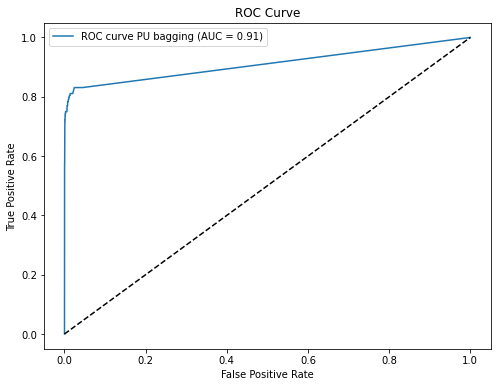

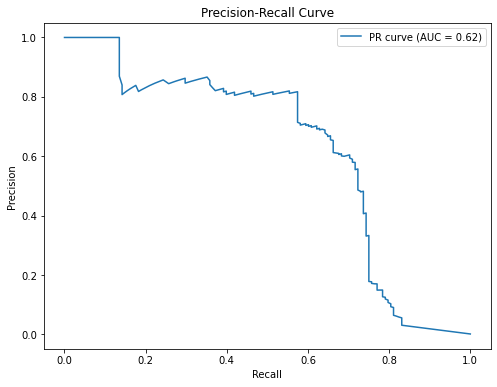

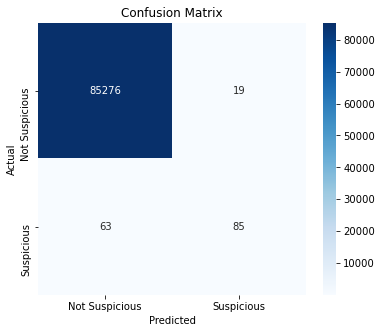

In [24]:
# ROC Curve 
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve PU bagging (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonale lijn (random classifier)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve 
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Confusion Matrix 
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Not Suspicious', 'Suspicious'], yticklabels=['Not Suspicious', 'Suspicious'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

fpr_pu, tpr_pu, _ = roc_curve(y_test, y_proba)
auc_pu = roc_auc_score(y_test, y_proba)

np.savez("roc_bagging(FRAUDE).npz",
         fpr=fpr_pu,
         tpr=tpr_pu,
         auc=auc_pu,
         labels=y_test,
         scores=y_proba)


In [19]:
np.save("preds_Bagging(FRAUDE).npy", y_pred)